In [6]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import os.path
import pickle # para leer los archivos comprimidos (.p)
 #enables zoom on figs
%matplotlib notebook
from datetime import datetime

###parameters######################
COM_ARDUINO_UNO = 'COM9'
baudrate_arduino= 250000#115200 #250000 #
SampleFreq = 1400 #Hz
tiempo_adq = 10 #4/SampleFreq#seg
filename = str(SampleFreq)+"hz_" + str(tiempo_adq)

    
date = datetime.today().strftime('%Y-%m-%')
print(date)

#'2021-01-26'


nombreArchivo = './mediciones/23112023_prueba2.p'# nombre del archivo donde guardar los datos
nsensores = 3 # 1 a 4
arduino_serial_plotter_protocol_on = 0 # data sent using arduino serial protocol (ascii for each digit) or send raw bytes
n_bytes_adc = 2 #length in bytes used for each sensor
################################################

cantidad_samples = np.int32(SampleFreq*tiempo_adq)   

def leer_sensor(arduino_puerto_serie, cantidad_samples):
    #initialize arrays
    samples_sensor0 = np.zeros((cantidad_samples))
    if nsensores >= 2 :        samples_sensor1 = np.zeros((cantidad_samples))
    if nsensores >= 3 :        samples_sensor2 = np.zeros((cantidad_samples))                         
    if nsensores >= 4 :        samples_sensor3 = np.zeros((cantidad_samples)) 
    arduino.reset_input_buffer()
    line = arduino.readline() 
    #if len(line) != nsensores*(n_bytes_adc+1): line = arduino.readline() 
    for n_samples in range(0,cantidad_samples):
        read_val = False
        while not read_val:
            try:
                if arduino_serial_plotter_protocol_on == 0:
                    line = arduino.read(nsensores*(n_bytes_adc+1)) #read fixed length, more robust when already in synch
                    while line[-1] != 10 or len(line) != nsensores*(n_bytes_adc+1): #synch: check last  byt is \n
                    #line = arduino.readline() #this sync can fail if it finds a value byte = 10 ascii for \n
                        print("sincronizando comunicación. dato descartado:"), print(len(line)), print(line)
                        for i in range(0,len(line)):
                            print(line[i]) # formato b'\x numero en hexa, si tiene ascii, imprime el ascii, sin \x'
                        line = arduino.readline() #read untill finding \n
                    samples_sensor0[n_samples] = float(line[1] + 256*line[0])
                    if nsensores >= 2 :  samples_sensor1[n_samples] = float(line[4] + 256*line[3]) 
                    if nsensores >= 3 :  samples_sensor2[n_samples] = float(line[7] + 256*line[6])                         
                    if nsensores >= 4 :  samples_sensor3[n_samples] = float(line[10] + 256*line[9])                         
                    read_val = True
                    #line = []
                if arduino_serial_plotter_protocol_on == 1: #adquiero con formato arduino serial plotter
                    line = arduino.readline() #hasta el proximo /n
                    string_n = line.decode()  # decode byte string into Unicode  
                    string = string_n.rstrip() # remove \n and \r
                    string_splitted = string.split(",")
                    samples_sensor0[n_samples] = float(string_splitted[0])
                    if nsensores >= 2 : samples_sensor1[n_samples] = float(string_splitted[1])
                    if nsensores >= 3 : samples_sensor2[n_samples] = float(string_splitted[2])
                    if nsensores >= 4 : samples_sensor3[n_samples] = float(string_splitted[3])
                    read_val = True
            except ValueError:
                print("Línea con error: {}".format(line))
# creo un diccionario para guardar mis datos
    if nsensores == 1 :  samples = {'sensor0' : samples_sensor0} 
    if nsensores == 2 :  samples = {'sensor0' : samples_sensor0,'sensor1' : samples_sensor1} 
    if nsensores == 3 :  samples = {'sensor0' : samples_sensor0,'sensor1' : samples_sensor1, 'sensor2' : samples_sensor2} 
    if nsensores == 4 :  samples = {'sensor0' : samples_sensor0,'sensor1' : samples_sensor1, 'sensor2' : samples_sensor2, 'sensor3' : samples_sensor3} 
    return samples #samples_sensor0, samples_sensor1, samples_sensor2

def guardar_datos(nombreArchivo, datos):
    while os.path.exists(nombreArchivo):# comprueba si el archivo existe
        #print("El archivo %s ya existe. Renombrando..." %nombreArchivo)
        path = os.path.split(nombreArchivo)[0]
        raw = os.path.splitext(os.path.split(nombreArchivo)[1])[0] #nombre archivo sin extension
        ext = os.path.splitext(os.path.split(nombreArchivo)[1])[1] #extension
        nombreArchivo = os.path.join(path, raw+'_'+ext)
    with open(nombreArchivo, 'wb') as f:
        pickle.dump(datos, f)
        print("Datos guardados en %s (se evita sobreescribir archivo con igual nombre)" %nombreArchivo)
        f.close()
    return nombreArchivo

2023-11-11/28/23


adquiriendo...
Datos guardados en ./mediciones\23112023_prueba2_____________________________________________.p (se evita sobreescribir archivo con igual nombre)


<IPython.core.display.Javascript object>


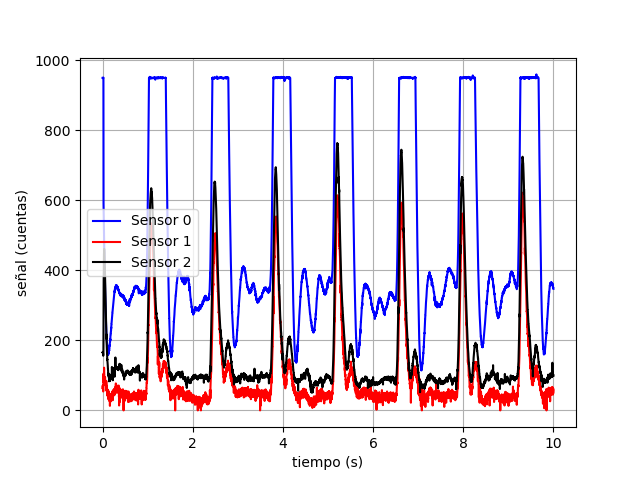

(<matplotlib.legend.Legend at 0x215e0290a60>, None, None)

In [345]:
# Abrimos la conexión con Arduino, adquiero, y guardo
# Hack cortesía de https://www.oreilly.com/library/view/python-cookbook/0596001673/ch17s02.html
try: arduino
except NameError:
    arduino = serial.Serial(COM_ARDUINO_UNO, baudrate=baudrate_arduino, timeout=1.0)
if not arduino.is_open: arduino.open()
#arduino.setDTR(False) #reset pin #al resetear, aparece un pico al principio
arduino.flushInput() 
#arduino.setDTR(True) #reset pin
print('adquiriendo...')
samples = leer_sensor(arduino,cantidad_samples)
arduino.close()

samples_sensor0 = samples['sensor0']
if nsensores >= 2 :    samples_sensor1 = samples['sensor1']
if nsensores >= 3 :    samples_sensor2 = samples['sensor2']
if nsensores >= 4 :    samples_sensor3 = samples['sensor3']
nombreArchivo = guardar_datos(nombreArchivo, samples)

# grafico de muestras completas
time = np.arange(0,cantidad_samples/SampleFreq,1/SampleFreq)
fig = plt.figure()
plt.plot(time,samples_sensor0, 'b', label="Sensor 0")
if nsensores >= 2 :    plt.plot(time,samples_sensor1, 'r', label="Sensor 1")
if nsensores >= 3 :    plt.plot(time,samples_sensor2, 'k', label="Sensor 2")
if nsensores >= 4 :    plt.plot(time,samples_sensor3, 'g', label="Sensor 3")

plt.xlabel("tiempo (s)"), plt.ylabel("señal (cuentas)")#plt.title("PULSOS ADQUIRIDOS")
plt.legend(), plt.grid(), plt.show() #plt.xlim([1000,30000])
